# Clover platform challenge

Background:

* Major need to provide context to care givers
* e.g. what chronic conditions a patient has
* Often have to infer context due to missing records


Objectives:

1. What are the most common medications for each disease in the base file?
1. What medications are most indicative of each disease?
1. Choose ONE of the diseases and build a model to infer whether that disease is present from the medications.
1. Demonstrate that the end user should be confident in the result
1. Bonus: Extend this to other diseases of interest, using
https://dl.dropboxusercontent.com/u/103227113/meps_curated/meps_conditions.csv
1. If you feel like going further: The source data set is meps (http://meps.ahrq.gov/mepsweb/ ). There is a lot more data in there (including medical costs and utilization). Add something you think is interesting. (An FYI: id in the curated dataset corresponds to DUPERSID in the raw files.)


**Methods:**

* Inspect and clean the data (see [scratch notebook](#inspect-data.ipynb))
* ...
* Check these:
    * data quality, e.g. duplicates
    * sanity check using other sources
    * interpretation of model performance


**Results:**

...


Discussion:

...

In [172]:
import pandas as pd
import numpy as np

from source.helpers import COLS_DX, load_base_data, load_meds_data

Base data

In [168]:
print load_base_data.__doc__ ####### will want to reuse and improve on this

load and prep base data for patients
    
    - remap diagnoses:
        yes -> True
        no -> False
        ['Inapplicable', 'DK', 'Refused', 'not ascertained'] -> NaN
    - exclude minors by default
    


In [219]:
df_base = load_base_data()
print len(df_base)
df_base.head()

42324


,panel,pooledWeight,age,sex,race,married,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,miDiagnosed,anginaDiagnosed,strokeDiagnosed,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed
id,,,,,,,,,,,,,,,,
10007101,15,3603.881236,28,Male,White,MARRIED,True,False,False,False,False,False,False,False,False,False
10007102,15,2544.550424,25,Female,White,MARRIED,False,False,False,False,False,False,False,True,False,False
10008101,15,3635.552466,51,Male,Multiple,MARRIED,False,False,False,False,False,False,False,False,False,False
10008102,15,4367.816253,53,Female,Asian,MARRIED,False,False,False,False,False,False,False,False,False,False
10009101,15,6241.938280,61,Female,Black,NEVER MARRIED,True,False,False,False,False,False,False,False,False,False


(from other [notebook](#inspect.ipynb))
> data prep summary 
* looks like one row per patient
* could potentially have some duplicates (<1%)
* not sure what `panel` or `pooledWeight` mean
* Threw out diagnoses besides Yes / No
* option to throw out data from minors (lots of "Inapplicable" values)

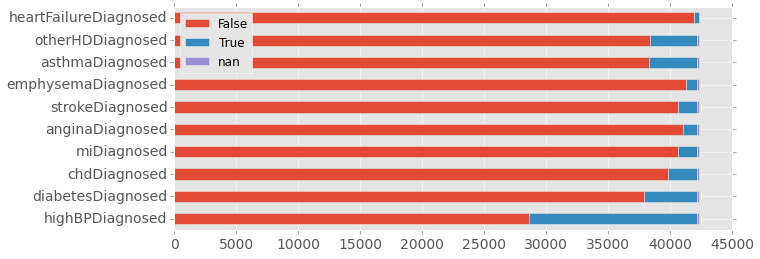

In [163]:
df_base[COLS_DX].apply(lambda ds: ds.value_counts(dropna=False)).T.plot.barh(stacked=True);

> lots of high blood pressure

### meds

In [214]:
print load_meds_data.__doc__

load and prep meds data

    - disambiguate drug names
    - collapse duplicate prescriptions per patient
    


In [223]:
df_meds = load_meds_data()
df_meds.head()

numPrescriptions                originalNDCs
id       rxNickname                                                
10007101 ATENOLOL                     4  [68382002210, 51079068463]
         AZITHROMYCIN                 1               [59762314001]
10007102 CARISOPRODOL                 1                 [603258228]
         HYDROCO                      1                 [406036005]
         TREXIMET                     2                 [173075000]

(from other [notebook](#inspect.ipynb))
> data prep summary
* looks like 1 row per prescription
* lots of ambigous drug names and NDCs, even per-patient
* drug nickname: 1st word in drug name
* collapsed data into unique drug nicknames per patient
    * keep original NDCs
    * count number of prescriptions per drug per patient in case useful

## What are the most common medications for each disease in the base file?
Could interpret as:
1. Among all patients with a specific disease, which meds are most common?  
(but could be confounded by other diseases)
2. Among patietns with _only_ a specific disease, which meds are most common?  
(maybe better?)

In [289]:
df = pd.merge(df_base.reset_index(), 
              df_meds.reset_index(), 
              how='inner',   # ignore patients without drugs
              left_on='id', 
              right_on='id')

In [279]:
print df.id.nunique(), 'patients'
print df.rxNickname.nunique(), 'drugs'
df.head(2)

30856 patients
3290 drugs


,id,panel,pooledWeight,age,sex,race,married,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,miDiagnosed,anginaDiagnosed,strokeDiagnosed,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed,rxNickname,numPrescriptions,originalNDCs
0,10007101,15,3603.881236,28,Male,White,MARRIED,True,False,False,False,False,False,False,False,False,False,ATENOLOL,4,"[68382002210, 51079068463]"
1,10007101,15,3603.881236,28,Male,White,MARRIED,True,False,False,False,False,False,False,False,False,False,AZITHROMYCIN,1,[59762314001]


### 1)
Rank meds by $P(M|D_i)$ for each disease $D_i$

e.g. high blood pressure

In [232]:
df[df.highBPDiagnosed == True].rxNickname.value_counts().head(3)

LISINOPRIL             3104
SIMVASTATIN            2418
HYDROCHLOROTHIAZIDE    1976
Name: rxNickname, dtype: int64

> Makes sense. Drugs for high lipids and blood pressure.

In [ ]:
n_top = 3

In [290]:
for dx in COLS_DX:
    has_disease = df[dx] == True
    cts = df[has_disease].rxNickname.value_counts()

    print dx
    print cts.head(n_top).to_string()
    print 'of', cts.sum(), 'patients diagnosed'
    print

highBPDiagnosed
LISINOPRIL             3104
SIMVASTATIN            2418
HYDROCHLOROTHIAZIDE    1976
of 109029 patients diagnosed

diabetesDiagnosed
METFORMIN      2156
LISINOPRIL     1251
SIMVASTATIN    1119
of 48235 patients diagnosed

chdDiagnosed
METOPROLOL     689
SIMVASTATIN    671
LISINOPRIL     615
of 26844 patients diagnosed

miDiagnosed
METOPROLOL     477
SIMVASTATIN    460
LISINOPRIL     446
of 18056 patients diagnosed

anginaDiagnosed
METOPROLOL     337
SIMVASTATIN    299
LISINOPRIL     274
of 14095 patients diagnosed

strokeDiagnosed
SIMVASTATIN    425
LISINOPRIL     383
PLAVIX         314
of 17453 patients diagnosed

emphysemaDiagnosed
ALBUTEROL     240
ADVAIR        193
LISINOPRIL    187
of 11436 patients diagnosed

asthmaDiagnosed
ALBUTEROL       726
AZITHROMYCIN    672
ADVAIR          639
of 31329 patients diagnosed

otherHDDiagnosed
LISINOPRIL     757
METOPROLOL     752
SIMVASTATIN    738
of 37512 patients diagnosed

heartFailureDiagnosed
FUROSEMIDE    239
LISINOPRIL  

> SIMVASTATIN and LISINOPRIL very common. Looks like high blood pressure comes along for the ride

### 2)
Rank meds by $P(M|D_i \cap \not D_k)$ for each disease $D_i$ and all other diseases $D_k, k \ne i$

In [291]:
for dx in COLS_DX:
    has_disease = df[dx] == True
    not_others = (df[COLS_DX].drop(dx, axis=1) == False).all(1)
    cts = df[has_disease & not_others].rxNickname.value_counts()

    print dx
    print cts.head(n_top).to_string()
    print 'of', cts.sum(), 'patients diagnosed with only this disease'
    print

highBPDiagnosed
LISINOPRIL             1148
HYDROCHLOROTHIAZIDE     912
AMLODIPINE              766
of 34681 patients diagnosed with only this disease

diabetesDiagnosed
METFORMIN     419
ONETOUCH      155
LISINOPRIL    145
of 5469 patients diagnosed with only this disease

chdDiagnosed
SIMVASTATIN    13
METOPROLOL     13
APAP            9
of 356 patients diagnosed with only this disease

miDiagnosed
METOPROLOL     8
HYDROCO        7
SIMVASTATIN    6
of 267 patients diagnosed with only this disease

anginaDiagnosed
AZITHROMYCIN    8
AMOXICILLIN     4
APAP            3
of 148 patients diagnosed with only this disease

strokeDiagnosed
SIMVASTATIN     24
AZITHROMYCIN    22
AMOXICILLIN     17
of 768 patients diagnosed with only this disease

emphysemaDiagnosed
SPIRIVA      19
ADVAIR       17
ALBUTEROL    12
of 593 patients diagnosed with only this disease

asthmaDiagnosed
AZITHROMYCIN    303
ALBUTEROL       279
ADVAIR          234
of 8206 patients diagnosed with only this disease

otherHDD

> ONETOUCH now shows up in top 3 drugs for Diabetes-only patients, which makes sense

## What medications are most indicative of each disease?
"Indicative" is tricky. Could interpret as:
1. drugs that are rarely taken when the disease is not present (high specificity)
2. drugs for which the diseases is common among those who take the drug (high positive predictivity)

### 1)
Rank meds by $P(\not M|\not D_i)$ for each disease.  
(limit to subset of common meds)

In [ ]:
n_common = 50 #150

In [302]:
for dx in COLS_DX:
    has_disease = df[dx] == True
    cts = df[has_disease].rxNickname.value_counts()
    common_meds = cts.head(n_common).index
    
    # subset of common meds most-infreqently found in patients without the disease
    cts = df[~has_disease].rxNickname.value_counts()[common_meds].sort_values()

    print dx
    print cts.head(n_top).to_string()
    print 'of', cts.sum(), 'patients diagnosed'
    print

highBPDiagnosed
BENICAR    27
DIOVAN     58
HCTZ       58
of 24605 patients diagnosed

diabetesDiagnosed
HUMALOG     7
NOVOLOG     8
HUMULIN    12
of 41793 patients diagnosed

chdDiagnosed
NITROGLYCERIN     62
ISOSORBIDE        72
DIGOXIN          166
of 51526 patients diagnosed

miDiagnosed
NITROGLYCERIN     88
ISOSORB           92
ISOSORBIDE       129
of 55281 patients diagnosed

anginaDiagnosed
ISOSORB           97
NITROGLYCERIN    103
ISOSORBIDE       153
of 59711 patients diagnosed

strokeDiagnosed
DIGOXIN      273
CLONIDINE    304
LANTUS       430
of 60930 patients diagnosed

emphysemaDiagnosed
IPRATROPIUM     88
COMBIVENT      127
SPIRIVA        145
of 59505 patients diagnosed

asthmaDiagnosed
FLOVENT       60
SYMBICORT     72
VENTOLIN     134
of 55338 patients diagnosed

otherHDDiagnosed
DIGOXIN       116
DILTIAZEM     260
CARVEDILOL    299
of 54277 patients diagnosed

heartFailureDiagnosed
SPIRONOLACT      129
NITROGLYCERIN    162
COREG            173
of 57847 patients diagnos

> seems to be pretty specific, but 
* the result depends on `n_common`, the size of the subset of common drugs
* the ideal size of the subset probably depends on the drug

### 2)
Rank meds by $PPV = P(D_i|M)$, the probability of having the disease, given the medication

In [ ]:
# use Bayes as a trick since we already have P(M|D)? (have to check)

for dx in COLS_DX:
    has_disease = df[dx] == True
    P_disease = has_disease /
    cts = df[has_disease].rxNickname.value_counts()

    print dx
    print cts.head(n_top).to_string()
    print 'of', cts.sum(), 'patients diagnosed'
    print

## Predict whether one disease is present from the medications

## Provide confidence level of result

## Bonus: extend to other diseases

## Further exploration